<a href="https://colab.research.google.com/github/abdullahkiani007/NeuralNet/blob/main/convet_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import cv2
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

In [ ]:
# Data Preprocessing
REBUILDING_DATA = True

class DogsVsCats():
  IMG_SIZE = 50
  CATS = "/content/train/cats"
  DOGS = "/content/train/dogs"
  LABELS = {CATS: 0, DOGS: 1}
  trainingData = []
  catCount = 0
  dogCount = 0

  def make_training_data(self):
    for label in self.LABELS:

      for f in tqdm(os.listdir(label)):

        try:
          path = os.path.join(label, f)
          img = cv2.imread(path, cv2.IMREAD_GRAYSCALE )
          img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
          # img = np.expand_dims(img, axis=2)

          # np.eye(2)[0] --> create one hot vector --> [1,0]
          label_encoded = np.eye(2)[self.LABELS[label]]
          self.trainingData.append( [np.array(img), label_encoded] )
          if label == self.CATS:
            self.catCount += 1
          elif label == self.DOGS:
            self.dogCount += 1
        except Exception as e:
          pass
    np.random.shuffle(self.trainingData)

    training_images = np.array([data[0] for data in self.trainingData])
    training_labels = np.array([data[1] for data in self.trainingData])

    # Save images and labels separately
    np.save("training_data_images.npy", training_images , allow_pickle=True)
    np.save("training_data_labels.npy", training_labels , allow_pickle=True)

    print("Cats:", self.catCount)
    print("Dogs:", self.dogCount)

if REBUILDING_DATA:
  dogsVscats = DogsVsCats()
  dogsVscats.make_training_data()


100%|██████████| 12501/12501 [00:15<00:00, 812.17it/s]


Cats: 12500
Dogs: 12500


In [ ]:
np.eye(2)[0]

array([1., 0.])

In [ ]:
print(os.path.exists("trainingData.npy"))

True


In [ ]:
# Assuming you have loaded your images and labels separately
training_data_images = np.load("training_data_images.npy", allow_pickle=True)
training_data_labels = np.load("training_data_labels.npy", allow_pickle=True)

# Verify shapes before stacking
print(f"Images shape: {training_data_images.shape}")
print(f"Labels shape: {training_data_labels.shape}")

# Stack images and labels in a tuple format
# Use 'object' directly instead of 'np.object'
training_data = np.empty((len(training_data_images),), dtype=object)
for i in range(len(training_data_images)):
    training_data[i] = (training_data_images[i], training_data_labels[i])


# Verify the shape of the merged array
print(f"Merged training data shape: {training_data.shape}")

Images shape: (25000, 50, 50)
Labels shape: (25000, 2)
Merged training data shape: (25000,)


(array([[164, 165, 156, ..., 194, 199, 196],
       [148, 155, 150, ..., 185, 202, 203],
       [154, 157, 139, ..., 186, 192, 203],
       ...,
       [ 97,  81,  59, ...,  77, 172, 172],
       [101,  81,  83, ..., 169, 172, 164],
       [108,  79,  60, ..., 185, 166, 165]], dtype=uint8), array([1., 0.]))


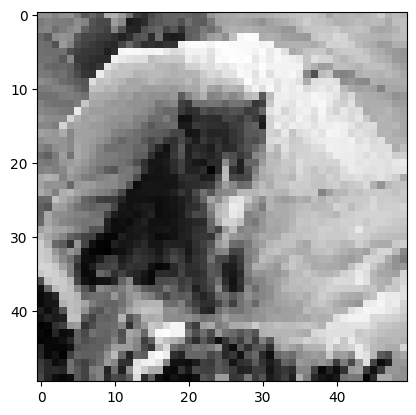

In [ ]:
print(training_data[0])
plt.imshow(training_data[0][0] ,cmap="gray")
plt.show()

In [ ]:
np.save("training_data.npy", training_data)

In [ ]:
training_data = np.load("training_data.npy" ,allow_pickle=True)

In [ ]:
#Mount your Google Drive files Following code make mount your google drive
from google.colab import drive
drive.mount('/content/gdrive')

 #   Now upload the kaggle.json file

from google.colab import files

files.upload() #this will prompt you to upload the kaggle.json

  #  make sure kaggle.json file is present
!ls -lha kaggle.json

#    Install kaggle API client
!pip install -q kaggle

#kaggle API client expects the file to be in ~/.kaggle
#so move it there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

#we need to set permissions
!chmod 600 /root/.kaggle/kaggle.json

#check your directory before downloading the datasets
!pwd

#list all available datasets
!kaggle datasets list

#download the required dataset from kaggle
!kaggle competitions download -c dogs-vs-cats

#If your file is a zip file you can unzip with the following code
!unzip dogs-vs-cats.zip

!unzip train.zip

# Create directories
!mkdir -p train/cats train/dogs

# Move cat images
!find . -type f -name 'cat*.*' -exec mv {} train/cats/ \;

# Move dog images
!find . -type f -name 'dog*.*' -exec mv {} train/dogs/ \;


Saving training_data.npy to training_data.npy


In [ ]:
!pwd

/content


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self._to_linear = None

        x = torch.rand(50,50)
        self.fc1 = None  # Initialize later
        self.fc2 = nn.Linear(512,2)


    def convs(self,x):
      x = F.max_pool2d(F.relu(self.conv1(x)), 2)
      x = F.max_pool2d(F.relu(self.conv2(x)), 2)
      x = F.max_pool2d(F.relu(self.conv3(x)), 2)

      if self.fc1 is None:
        x_shape = x[0].shape
        self._to_linear = x_shape[0] * x_shape[1] * x_shape[2]
        self.fc1 = nn.Linear(self._to_linear, 512)

      return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x,dim=1)

net = Net()
input_image = torch.randn(1, 1, 50, 50)
output = net(input_image)


In [ ]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0

Y = torch.Tensor([i[1] for i in training_data])

<ipython-input-7-ae3dd2871f8f>:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)


In [ ]:
VAL_PCT = 0.1
val_size = int(len(X)* VAL_PCT)

train_x = X[:-val_size]
train_y = Y[:-val_size]

test_x = X[-val_size:]
test_y = X[-val_size:]

In [ ]:
BATCH_SIZE = 100
EPOCHS = 1

for epoch in range(EPOCHS):
  for i in tqdm(range(0, len(train_x), BATCH_SIZE)):
    batch_x = train_x[i:i+BATCH_SIZE].view(-1,1,50,50)
    batch_y = train_y[i:i+BATCH_SIZE]
    net.zero_grad()
    outputs = net(batch_x)
    loss = loss_function(outputs, batch_y)
    loss.backward()
    optimizer.step()

  print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss}")

100%|██████████| 225/225 [02:04<00:00,  1.81it/s]

Epoch 1/1, Loss: 0.22311797738075256


In [ ]:
BATCH_SIZE = 100
EPOCHS = 1

correct = 0
total = 0

with torch.no_grad():
    for i in tqdm(range(0, len(test_x), BATCH_SIZE)):
        batch_x = test_x[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = test_y[i:i+BATCH_SIZE]
        outputs = net(batch_x)

        # Get the predicted class
        _, predicted = torch.max(outputs, 1)

        # Update the total count
        total += batch_y.size(0)
        print(outputs)

        # Update the correct count
        correct += (predicted == batch_y).sum().item()

# Calculate the accuracy
accuracy = 100 * correct / total
print(f'Accuracy of the network on the {total} test images: {accuracy:.2f} %')

  0%|          | 0/25 [00:01<?, ?it/s]


RuntimeError: The size of tensor a (100) must match the size of tensor b (50) at non-singleton dimension 2

In [ ]:
import pandas as pd
import tqdm

features= pd.read_csv("interview_transcripts_by_turkers.csv")
turker_score = pd.read_csv('turker_scores_full_interview.csv')

In [ ]:
trait_result_df = pd.DataFrame(features[:7], columns=['Top Feature 1', 'Top Feature 2', 'Top Feature 3',
                                                          'Top Feature 4', 'Top Feature 5', 'Top Feature 6',
                                                          'Top Feature 7'])
print(trait_result_df)

   Top Feature 1  Top Feature 2  Top Feature 3  Top Feature 4  Top Feature 5  \
0            NaN            NaN            NaN            NaN            NaN   
1            NaN            NaN            NaN            NaN            NaN   
2            NaN            NaN            NaN            NaN            NaN   
3            NaN            NaN            NaN            NaN            NaN   
4            NaN            NaN            NaN            NaN            NaN   
5            NaN            NaN            NaN            NaN            NaN   
6            NaN            NaN            NaN            NaN            NaN   

   Top Feature 6  Top Feature 7  
0            NaN            NaN  
1            NaN            NaN  
2            NaN            NaN  
3            NaN            NaN  
4            NaN            NaN  
5            NaN            NaN  
6            NaN            NaN  


RangeIndex(start=0, stop=1378, step=1)
    Participant   Overall  RecommendHiring  Colleague   Engaged   Excited  \
0            p1  5.255257         5.011803   5.259223  5.615709  5.227099   
1           p10  4.636124         4.606595   4.623098  4.868082  4.153772   
2           p11  5.001159         4.503645   4.759689  4.995317  4.144196   
3           p12  5.337614         5.325025   5.811300  5.607812  5.258058   
4           p13  4.361250         4.480614   4.476516  4.733128  3.064390   
..          ...       ...              ...        ...       ...       ...   
133        pp83  5.893972         5.978513   6.594208  6.138136  5.978513   
134        pp84  5.634453         6.002256   5.493023  5.527773  5.589696   
135        pp85  5.402897         5.640732   5.754597  6.486180  5.842759   
136        pp86  4.983765         4.855575   4.499470  5.501548  5.237516   
137        pp89  4.884454         4.485563   5.127009  5.126526  4.489778   

     EyeContact    Smiled  SpeakingR

In [ ]:
import pandas as pd

# Example MI scores (replace this with loading your actual MI scores DataFrame)
data = {
    'Trait': ['Filler Words', 'We Count', 'Engaged', 'Smiled', 'Speaking Rate'],
    'Overall': [0.007324734, 0.0, 0.034081128, 0.0, 0.022271921],
    'RecommendHiring': [0.067357953, 0.110020891, 0.11135889, 0.0, 0.0],
    'Colleague': [0.060976955, 0.015240135, 0.015240135, 0.0, 0.0],
    'Engaged': [0.034081128, 0.019612884, 0.019612884, 0.111061511, 0.0],
    'Excited': [0.0, 0.11135889, 0.099627234, 0.111061511, 0.107052822],
}

# Create DataFrame from the data (replace `data` with your actual DataFrame)
mi_scores = pd.DataFrame(data)

# Function to select top features based on MI scores for a specific outcome
def select_top_features(mi_scores_df, outcome_column, top_n=5):
    # Sort by MI score for the specified outcome column
    sorted_features = mi_scores_df.sort_values(by=outcome_column, ascending=False)

    # Select top N features based on MI score
    top_features = sorted_features.head(top_n)['Trait'].tolist()

    return top_features

# Example usage: Select top features for 'RecommendHiring'
top_features_recommend_hiring = select_top_features(mi_scores, 'RecommendHiring', top_n=3)
print("Top features for RecommendHiring:", top_features_recommend_hiring)

# Example usage: Select top features for 'Overall'
top_features_overall = select_top_features(mi_scores, 'Overall', top_n=3)
print("Top features for Overall:", top_features_overall)


Top features for RecommendHiring: ['Engaged', 'We Count', 'Filler Words']
Top features for Overall: ['Engaged', 'Speaking Rate', 'Filler Words']


In [ ]:
!pip install praat-parselmouth

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 71.4 MB/s eta 0:00:00


In [ ]:
!pip install sounddevice scipy

In [ ]:
import parselmouth
from parselmouth.praat import call
import pandas as pd
import os

In [ ]:
def extract_features(audio_path):
    sound = parselmouth.Sound(audio_path)
    audio_file_name = os.path.basename(audio_path)  # Extract the audio file name without path

    # Duration
    duration = call(sound, "Get total duration")

    # Pitch (F0)
    pitch = call(sound, "To Pitch", 0.0, 75, 600)
    mean_pitch = call(pitch, "Get mean", 0, 0, "Hertz")
    min_pitch = call(pitch, "Get minimum", 0, 0, "Hertz")
    max_pitch = call(pitch, "Get maximum", 0, 0, "Hertz")
    pitch_sd = call(pitch, "Get standard deviation", 0, 0, "Hertz")
    pitch_range = max_pitch - min_pitch

    # Intensity
    intensity = call(sound, "To Intensity", 75, 0.0)
    mean_intensity = call(intensity, "Get mean", 0, 0, "dB")
    min_intensity = call(intensity, "Get minimum", 0, 0)
    max_intensity = call(intensity, "Get maximum", 0, 0)
    intensity_sd = call(intensity, "Get standard deviation", 0, 0, "dB")
    intensity_range = max_intensity - min_intensity

    # Formants
    formant = call(sound, "To Formant (burg)", 0.0, 5, 5500, 0.025, 50)
    f1_mean = call(formant, "Get mean", 1, 0, 0, "Hertz")
    f2_mean = call(formant, "Get mean", 2, 0, 0, "Hertz")
    f3_mean = call(formant, "Get mean", 3, 0, 0, "Hertz")
    f1_sd = call(formant, "Get standard deviation", 1, 0, 0, "Hertz")
    f2_sd = call(formant, "Get standard deviation", 2, 0, 0, "Hertz")
    f3_sd = call(formant, "Get standard deviation", 3, 0, 0, "Hertz")

    # Bandwidth
    f1_bw = call(formant, "Get bandwidth at time", 1, 0.0, "Hertz")
    f2_bw = call(formant, "Get bandwidth at time", 2, 0.0, "Hertz")
    f3_bw = call(formant, "Get bandwidth at time", 3, 0.0, "Hertz")
    f1_f2_ratio_mean = f2_mean / f1_mean
    f1_f3_ratio_mean = f3_mean / f1_mean
    f1_f2_ratio_sd = f2_sd / f1_mean
    f1_f3_ratio_sd = f3_sd / f1_mean

    # Jitter and Shimmer
    point_process = call(sound, "To PointProcess (periodic, cc)", 75, 600)
    jitter = call(point_process, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    shimmer = call(point_process, "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.0)  # Added Maximum amplitude factor

    # Voicing
    voiced_frames = call(pitch, "Count voiced frames")
    total_frames = call(pitch, "Get number of frames")
    percent_unvoiced = 100 * (total_frames - voiced_frames) / total_frames

    # Breaks and Pauses
    # Adjusted to avoid using unavailable commands
    breaks = call(point_process, "Get number of voice breaks")
    longest_pause = call(point_process, "Get maximum voice break")
    total_pause_duration = sum(call(point_process, "Get voice break", i) for i in range(1, breaks + 1))
    avg_pause_duration = total_pause_duration / breaks if breaks != 0 else 0

    features = {
        'id': audio_file_name,  # The participant ID as the filename
        'duration': duration,
        'mean_pitch': mean_pitch,
        'min_pitch': min_pitch,
        'max_pitch': max_pitch,
        'pitch_range': pitch_range,
        'pitch_sd': pitch_sd,
        'mean_intensity': mean_intensity,
        'min_intensity': min_intensity,
        'max_intensity': max_intensity,
        'intensity_range': intensity_range,
        'intensity_sd': intensity_sd,
        'f1_mean': f1_mean,
        'f2_mean': f2_mean,
        'f3_mean': f3_mean,
        'f1_sd': f1_sd,
        'f2_sd': f2_sd,
        'f3_sd': f3_sd,
        'f1_bw': f1_bw,
        'f2_bw': f2_bw,
        'f3_bw': f3_bw,
        'f1_f2_ratio_mean': f1_f2_ratio_mean,
        'f1_f3_ratio_mean': f1_f3_ratio_mean,
        'f1_f2_ratio_sd': f1_f2_ratio_sd,
        'f1_f3_ratio_sd': f1_f3_ratio_sd,
        'jitter': jitter,
        'shimmer': shimmer,
        'percent_unvoiced': percent_unvoiced,
        'num_voice_breaks': breaks,
        'percent_breaks': 100 * breaks / total_frames if total_frames > 0 else 0,
        'max_dur_pause': longest_pause,
        'avg_dur_pause': avg_pause_duration
    }

    return features

def write_features_to_csv(features_list, output_csv):
    df = pd.DataFrame(features_list)
    df.to_csv(output_csv, index=False)

audio_files = os.listdir("audio_files/Audio")
all_features = []

for audio_file in audio_files:
    audio_path = os.path.join("audio_files/Audio", audio_file)
    features = extract_features(audio_path)
    all_features.append(features)

output_csv = "all_features.csv"
write_features_to_csv(all_features, output_csv)

print("All features have been written to the CSV file.")
